In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Experiment class, object created by the raw experiment output files

In [162]:
class Experiment():
  def __init__(self,flags,mcts_configs,stats_keys,scores,progress,game_stats,player_stats,avg_score,avg_progress
               ,avg_time,errors,game_stats_full=None,player_stats_full=None):
    self.name = flags["agent"]+" vs "+flags["agents"]
    if flags["agent"] == 'MCTSAgent' or flags["agents"] == 'MCTSAgent':
      self.name += " "+self.mcts_type_to_string(flags["mcts_types"][0])
    self.flags = flags
    self.mcts_configs = mcts_configs
    self.scores = scores
    self.progress = progress
    self.stats_keys = stats_keys
    self.game_stats = game_stats #lsit
    self.game_stats_full = game_stats_full
    self.player_stats = player_stats
    self.player_stats_full = player_stats_full
    self.avg_score = avg_score
    self.avg_time = avg_time
    self.errors = errors
    self.game_df = self.convert_to_df(game_stats)
    self.player_dfs = []
    for i in range(len(self.player_stats)):
      player_df = self.convert_to_df(player_stats[i])
      player_df["information_perc"] = player_df["information"]/(player_df["moves"].replace(0,1))
      player_df["discard_perc"] = player_df["discard"]/(player_df["moves"].replace(0,1))
      player_df["play_perc"] = player_df["play"]/(player_df["moves"].replace(0,1))
      self.player_dfs.append(player_df)
     
  def convert_to_df(self, stat_list):
    stat_df = pd.DataFrame({stat_string:[s[self.stat_index(stat_string)] for s in stat_list] for stat_string in self.stats_keys})
    return stat_df

  def stat(self,stat_string):
    return self.game_df[stat_string]
  
  def player_stat(self,stat_string,player=0):
    return self.player_dfs[player][stat_string]
  
  def nonzero(self,stat_string):
    return (self.game_df[stat_string] != 0).sum() / len(self.game_df)
  
  def avg(self,stat_string):
    return sum(self.game_df[stat_string])/len(self.game_df)
  
  def player_individual_avg(self,stat_string, player=0):
    """Take a player's df. Compute average"""
    return sum(self.player_dfs[player][stat_string])/len(self.player_dfs[player])
  
  def players_avg(self, stat_string,players=[0,1,2]):
    stat_sum = 0
    for player in players:
      stat_sum += self.player_individual_avg(stat_string, player)
    return stat_sum/len(players)
      
  def players_perc_nonzero(self,stat_string,players=[0]):
    stat_sum = 0
    for player in players:
      stat_sum += (self.player_dfs[player][stat_string] != 0).sum() / len(self.player_dfs[player])
    return stat_sum/len(players)
  
  def compute_avg_stat_raw(self,stat_string):
    total_score = sum([game[self.stat_index(stat)] for game in self.game_stats])
    return total_score/len(self.game_stats)
  
  def stat_index(self,stat_string):
    return self.stats_keys.index(stat_string)

  def mcts_type_to_string(self,mcts_type):
    if mcts_type == '0': #default
      return 'default'
    elif mcts_type == '1': #regret
      return 'regret'
    elif mcts_type == '2': #c_regret
      return 'c_regret'
    elif mcts_type == '3': #detnone
      return 'detnone'
    elif mcts_type == '4': #detnone_rulesnone
      return 'detnone_rulesnone'
    elif mcts_type == '5': #detnone_random_rulesnone
      return 'detnone_random_rulesnone'
    elif mcts_type == '6': #detnone_regret_depth1
      return 'detnone_regret_depth1'
    elif mcts_type == '7': #c
      return 'c'
    elif mcts_type == '8': #rulesnone
      return 'rulesnone'
    elif mcts_type == '9': #detnone_regret
      return 'detnone_regret'
    elif mcts_type == 'a': #regret_rulesnone
      return 'regret_rulesnone'
    elif mcts_type == 'b': #detnone_regret_rulesnone
      return 'detnone_regret_rulesnone'
    elif mcts_type == 'c': #detnone_c
      return 'detnone_c'
    else:
      return 'error'
    
  
  def __str__(self):
    return str(self.flags)

  def __repr__(self):
    return str(self.flags)

Define notebook functions

In [148]:
def explain_experiment(exp):
    print(exp.name)
    print(exp)
    print(exp.mcts_configs)
    print(f"Available stats: {exp.stats_keys}")
    print(f"Scores: {exp.scores}")
    print(f"Progress: {exp.progress}")
    print(f"Printed average game score {exp.avg_score}")
    print(f"Computed average game score {exp.avg('score')}")
    print(f"Computed average game progress {exp.avg('progress')}")
    print(f"Computed average game regret {exp.avg('regret')}")

def row_experiment(exp,players=[0]):
  """Squish experiment into one row"""
  exp_dict = {}
  exp_dict["name"] = exp.name
  exp_dict["avg_score"] = exp.avg("score")
  exp_dict["avg_progress"] = exp.avg("progress")
  exp_dict["avg_regret"] = exp.avg("regret")
  exp_dict["regret"] = exp.players_avg("regret",players), 
  exp_dict["regret_perc"] = exp.players_perc_nonzero("regret",players)
  exp_dict["regret_discard"] = exp.players_avg("regret_discard_critical",players)
  exp_dict["regret_discard_perc"]= exp.players_perc_nonzero("regret_discard_critical",players)
  exp_dict["regret_play"] = exp.players_avg("regret_play_fail",players)
  exp_dict["regret_play_perc"]= exp.players_perc_nonzero("regret_play_fail",players)
  exp_dict["regret_endgame"] = exp.players_avg("regret_play_fail_endgame",players)
  exp_dict["regret_endgame_perc"]= exp.players_perc_nonzero("regret_play_fail_endgame",players)
  exp_dict["info"] = exp.players_avg("information",players)
  exp_dict["info_perc"] = exp.players_avg("information_perc",players)
  exp_dict["discard"] = exp.players_avg("discard",players) 
  exp_dict["discard_perc"]=   exp.players_avg("discard_perc",players)
  exp_dict["play"] = exp.players_avg("play",players)
  exp_dict["play_perc"] = exp.players_avg("play_perc",players)
  exp_df = pd.DataFrame(exp_dict)
  return exp_df

def experiments_dict_to_df(experiment_dict,players=[0,1,2], decimals=2):
  return pd.concat([row_experiment(exp,players) for k,exp in experiment_dict.items()]).round(decimals)

def mixed_experiments_dict_to_df(experiment_dict,second_players=[1,2],decimals=2):
  experiment_df = experiments_dict_to_df(experiment_dict,[0],decimals)
  experiment_df = condense_experiments_df(experiment_df, True)
  # Pull same df for 2p agents
  experiment_df_2p = experiments_dict_to_df(experiment_dict,second_players,decimals)
  experiment_df_2p = condense_experiments_df(experiment_df_2p,True)
  # Cut off the Team stats from 2p (but keep name)
  keep_cols = list(experiment_df_2p.columns)[:1] +list(experiment_df_2p.columns)[4:]
  experiment_df_2p = experiment_df_2p[keep_cols]
  return pd.merge(experiment_df,experiment_df_2p, on="name", how="left", suffixes=("","_2"))

def self_experiments_dict_to_df(experiment_dict,players=[0,1,2],decimals=2):
  experiment_df = experiments_dict_to_df(experiment_dict,players,decimals)
  return condense_experiments_df(experiment_df,mixed=False)

def condense_experiments_df(experiment_df,mixed=False):
  """Remove superfluous columns"""
  drop_cols = ["info","discard","play"]
  if mixed:
    drop_cols += ["info_perc","discard_perc","play_perc","regret_discard_perc","regret_perc","regret_play_perc","regret_endgame_perc"]
  return experiment_df.drop(columns=drop_cols, inplace=False)

def plot_hist(series,xlabel="x",ylabel="y",title="",xlim=None,ylim=None,bins=None):
  """Series is a dict {name:data}"""
  fig, ax = plt.subplots()
  for name,s in series.items():
    if bins is None:
      bins = np.arange(0, s.max() + 1.5) - 0.5
    ax.hist(s,bins,alpha=0.5, label=name)
  plt.legend(loc='upper left')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  if xlim:
    ax.set_xlim(xlim)
  if ylim:
    ax.set_ylim(ylim)

  plt.show()

Read in data`

In [177]:
# Each file is a list of experiments
file_names = {"vrun_rulebased3p":"vrun_rulebased_2/vrun_rulebased3p.sh.o"
             ,"vrun_mcts_c_regret":"vrun_mcts_2/vrun_mcts_c_regret.sh.o1215729"
             ,"vrun_mcts_default":"vrun_mcts_2/vrun_mcts_default.sh.o1215727"
             ,"vrun_mcts_detnone_random_rulesnone":"vrun_mcts_2/vrun_mcts_detnone_random_rulesnone.sh.o1215733"
             ,"vrun_mcts_detnone_regret_depth1":"vrun_mcts_2/vrun_mcts_detnone_regret_depth1.sh.o1215734"
             ,"vrun_mcts_detnone_rulesnone":"vrun_mcts_2/vrun_mcts_detnone_rulesnone.sh.o1215732"
             ,"vrun_mcts_detnone":"vrun_mcts_2/vrun_mcts_detnone.sh.o1215731"
             ,"vrun_mcts_regret":"vrun_mcts_2/vrun_mcts_regret.sh.o1215737"
             ,"vrun_mcts_c":"vrun_mcts_3/vrun_mcts_c.sh.o1215953"
             ,"vrun_mcts_detnone_regret_rulesnone":"vrun_mcts_3/vrun_mcts_detnone_regret_rulesnone.sh.o1215958"
             ,"vrun_mcts_detnone_regret":"vrun_mcts_3/vrun_mcts_detnone_regret.sh.o1215955"
             ,"vrun_mcts_regret_rulesnone":"vrun_mcts_3/vrun_mcts_regret_rulesnone.sh.o1215957"
             ,"vrun_mcts_rulesnone":"vrun_mcts_3/vrun_mcts_rulesnone.sh.o1215954"
             ,"vrun_mcts_detnone_c":"vrun_mcts_3/vrun_mcts_detnone_c.sh.o1216265"
             ,"mix_rulebased":"mix_rulebased/mix_rulebased.txt"
             }
master_experiments = {}

for k,v in file_names.items():
  experiments_store = None
  experiments = None
  exec(open(v).read()) # Defines a list of experiments (eg. 2p - 5p)
  assert experiments_store is not None or experiments is not None
  if experiments_store is not None: # Handle legeacy case where it was set to experiments_store
    experiments = experiments_store
  for i in range(len(experiments)):
    master_experiments[k+"_"+str(i)] = experiments[i]

experiment_list = [v for k,v in master_experiments.items()]
experiment_dict = {exp.name:exp for k,exp in master_experiments.items()}

for exp in experiment_list:
  explain_experiment(exp)

MuteAgent vs MuteAgent
{'players': 3, 'num_episodes': 250, 'agent': 'MuteAgent', 'agents': 'MuteAgent', 'mcts_types': '000', 'agent_classes': ['MuteAgent', 'MuteAgent', 'MuteAgent']}
[]
Available stats: ['score', 'progress', 'moves', 'regret', 'regret_discard_critical', 'regret_play_fail', 'regret_play_fail_critical', 'regret_play_fail_endgame', 'discard', 'discard_critical', 'discard_useful', 'discard_safe', 'play', 'play_success', 'play_fail', 'play_fail_critical', 'play_fail_endgame', 'information', 'information_color', 'information_rank', 'elapsed_time']
Scores: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Double check config of an experiment

In [188]:
explain_experiment(experiment_dict["MCTSAgent vs MCTSAgent regret"])

MCTSAgent vs MCTSAgent regret
{'players': 3, 'num_episodes': 100, 'agent': 'MCTSAgent', 'agents': 'MCTSAgent', 'mcts_types': '111', 'agent_classes': ['MCTSAgent', 'MCTSAgent', 'MCTSAgent']}
[{'max_time_limit': 10000, 'max_rollout_num': 100, 'agents': '[<agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2b3d68c3c208>, <agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2b3d68c3c240>, <agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2b3d68c3c198>]', 'max_simulation_steps': 3, 'max_depth': 100, 'determine_type': 0, 'score_type': 1, 'exploration_weight': 2.5, 'playable_now_convention': False, 'playable_now_convention_sim': False, 'rules': '[<function Ruleset.tell_most_information_factory.<locals>.tell_most_information at 0x2b3d71922c80>, <function Ruleset.tell_anyone_useful_card at 0x2b3d71906598>, <function Ruleset.tell_dispensable_factory.<locals>.tell_dispensable at 0x2b3d68c53400>, <function Ruleset.complete_tell_useful at 0x2b3d71906b70>, 

Analyse as self play stats (1 lot of detailed player stats averaged across [0,1,2])

In [178]:
self_df = self_experiments_dict_to_df(master_experiments)
self_df.sort_values(by="avg_score")

,name,avg_score,avg_progress,avg_regret,regret,regret_perc,regret_discard,regret_discard_perc,regret_play,regret_play_perc,regret_endgame,regret_endgame_perc,info_perc,discard_perc,play_perc
0,MuteAgent vs MuteAgent,0.00,1.26,25.00,8.33,0.43,0.00,0.00,8.33,0.43,8.20,0.33,0.00,0.00,1.00
0,LegalRandomAgent vs LegalRandomAgent,0.00,1.36,25.00,8.33,0.52,0.28,0.17,8.05,0.41,7.90,0.33,0.53,0.18,0.28
0,FlawedAgent vs FlawedAgent,0.00,1.46,25.00,8.33,0.43,0.00,0.00,8.33,0.43,8.18,0.33,0.05,0.00,0.95
0,FlawedAgent vs VanDenBerghAgent,0.14,5.67,24.84,8.28,0.40,0.13,0.08,8.15,0.33,8.05,0.33,0.45,0.07,0.48
0,FlawedAgent vs PiersAgent,0.21,5.67,24.77,8.26,0.43,0.21,0.12,8.05,0.33,7.93,0.33,0.43,0.09,0.48
0,LegalRandomAgent vs PiersAgent,0.47,6.54,24.38,8.13,0.64,1.11,0.45,7.01,0.34,6.84,0.32,0.48,0.23,0.28
0,FlawedAgent vs IGGIAgent,0.51,6.05,24.42,8.14,0.43,0.24,0.13,7.90,0.32,7.77,0.32,0.44,0.11,0.46
0,FlawedAgent vs OuterAgent,0.54,6.16,24.35,8.12,0.43,0.21,0.12,7.90,0.33,7.77,0.32,0.47,0.09,0.45
0,LegalRandomAgent vs OuterAgent,0.72,5.76,23.94,7.98,0.60,0.98,0.42,7.00,0.32,6.82,0.31,0.50,0.24,0.26
0,LegalRandomAgent vs VanDenBerghAgent,0.76,6.12,23.85,7.95,0.57,0.91,0.39,7.04,0.33,6.89,0.31,0.49,0.23,0.28


Analyse as mixed stats(2 lots of fewer players stats averaged across [0],[1,2] resectively)

In [119]:
mixed_df = mixed_experiments_dict_to_df(master_experiments)
mixed_df

,name,avg_score,avg_progress,avg_regret,regret,regret_discard,regret_play,regret_endgame,regret_2,regret_discard_2,regret_play_2,regret_endgame_2
0,MuteAgent vs MuteAgent,0.00,1.26,25.00,8.14,0.00,8.14,7.98,8.43,0.00,8.43,8.31
1,LegalRandomAgent vs LegalRandomAgent,0.00,1.36,25.00,8.80,0.27,8.52,8.37,8.10,0.28,7.82,7.67
2,FlawedAgent vs FlawedAgent,0.00,1.46,25.00,9.15,0.00,9.15,9.01,7.93,0.00,7.93,7.77
3,InnerAgent vs InnerAgent,10.68,10.68,10.02,3.21,3.21,0.00,0.00,3.41,3.41,0.00,0.00
4,OuterAgent vs OuterAgent,15.35,15.35,6.24,2.04,2.04,0.00,0.00,2.10,2.10,0.00,0.00
5,IGGIAgent vs IGGIAgent,15.90,15.90,6.36,2.09,2.09,0.00,0.00,2.13,2.13,0.00,0.00
6,PiersAgent vs PiersAgent,16.93,16.93,5.77,1.84,1.70,0.14,0.00,1.96,1.80,0.16,0.00
7,VanDenBerghAgent vs VanDenBerghAgent,17.12,17.12,3.95,1.19,1.10,0.08,0.00,1.38,1.31,0.07,0.00
8,MuteAgent vs OuterAgent,16.02,16.02,5.09,3.38,3.14,0.24,0.00,0.86,0.86,0.00,0.00
9,MuteAgent vs IGGIAgent,15.69,16.02,6.54,3.89,2.86,1.03,0.85,1.33,1.16,0.17,0.17


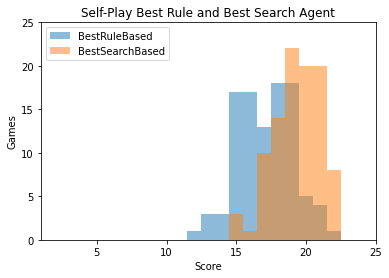

In [185]:
name = ["VanDenBerghAgent vs VanDenBerghAgent","MCTSAgent vs MCTSAgent detnone_c"]
series = {"BestRuleBased":experiment_dict[name[0]].game_df["score"][0:100]
         ,"BestSearchBased":experiment_dict[name[1]].game_df["score"][0:100]}
plot_hist(series,xlabel="Score",ylabel="Games", title="Self-Play Best Rule and Best Search Agent", xlim=(1,25),ylim=(0,25))

In [180]:
explain_experiment(experiment_dict["MCTSAgent vs MCTSAgent detnone_regret"])

MCTSAgent vs MCTSAgent detnone_regret
{'players': 3, 'num_episodes': 100, 'agent': 'MCTSAgent', 'agents': 'MCTSAgent', 'mcts_types': '999', 'agent_classes': ['MCTSAgent', 'MCTSAgent', 'MCTSAgent']}
[{'max_time_limit': 10000, 'max_rollout_num': 100, 'agents': '[<agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2b72bb237208>, <agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2b72bb237240>, <agents.rule_based.rule_based_agents.VanDenBerghAgent object at 0x2b72bb237198>]', 'max_simulation_steps': 3, 'max_depth': 100, 'determine_type': 0, 'score_type': 1, 'exploration_weight': 2.5, 'playable_now_convention': False, 'playable_now_convention_sim': False, 'rules': '[<function Ruleset.tell_most_information_factory.<locals>.tell_most_information at 0x2b72c3f1cc80>, <function Ruleset.tell_anyone_useful_card at 0x2b72c3f01598>, <function Ruleset.tell_dispensable_factory.<locals>.tell_dispensable at 0x2b72bb24f400>, <function Ruleset.complete_tell_useful at 0x2b72c3f

In [131]:
sum(experiment_dict["OuterAgent vs OuterAgent"].game_df["score"] == 13)

15